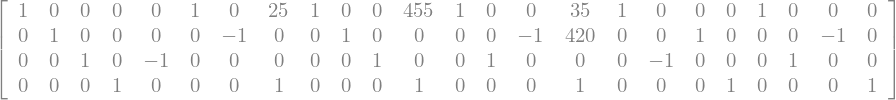

In [17]:
import open3d as o3d
import numpy as np
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, mechanics_printing
mechanics_printing()
import modern_robotics as mr

# %run task_21_to_24_jupyter.ipynb
import import_ipynb 
import task_21_to_24_jupyter

### Symbolic functions

#### Variables from 2.1-2.4

In [23]:
# th1, th2, th3, th4, th5, th6 = dynamicsymbols('theta_1, theta_2, theta_3, theta_4, theta_5, theta_6')

# config = Matrix([[0,0,0,th1],[pi/2,0,0,th2 + pi/2],[0,455,0,th3],[pi/2, 35, -420, th4],[-pi/2,0,0,th5],[pi/2, 0, -80,th6]])

# Mi = Matrix([[eye(4)]*6])

# for i in range(6):
#     if i == 1:
#         Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2]) * rotZ(-pi/2) # We compansate for the rotation of -pi/2 done when finding the D-H parameters 
#     else:
#         Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2])

# M = eye(4)
# for n in range(5,-1,-1):
#     M = Mi[:,4*n:4*(n+1)] * M

#     Ai = Matrix([[0,-1,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]]) # This is a given matrix due to revolute joints

# S_sp = zeros(6)
# for i in range(6):
#     dot_sum = eye(4)
#     for n in range(i,-1,-1):
#         dot_sum = Mi[:,4*n:4*(n+1)] * dot_sum
#     S_skew = dot_sum * Ai * Inverse(dot_sum)
#     S_sp[0,i] = S_skew[2,1] 
#     S_sp[1,i] = S_skew[0,2] 
#     S_sp[2,i] = S_skew[1,0] 
#     S_sp[3,i] = S_skew[0,3] 
#     S_sp[4,i] = S_skew[1,3] 
#     S_sp[5,i] = S_skew[2,3] 

# M_inv = mr.TransInv(M)          #Finding inverse of M
# Ad_M_inv = mr.Adjoint(M_inv)    #Computing [Ad_M^-1]

# #Using B_i = [Ad_M^-1]S_i
# S_bp = zeros(6,6)
# for i in range(6):
#      S_bp[:, i] = Ad_M_inv * S_sp[:, i]


## Task 2.5

In [18]:
class RobotObject:
    robotObjects = [o3d.geometry.TriangleMesh.create_coordinate_frame(size=75)] #List of all o3d objects, initialized with {s}-frame

    def __init__(self, num_joints, length_links, link_orient = 'x'):
        self.num_joints = num_joints
        self.length_links = length_links
        self.link_orient = ['x']*(len(link_lengths)+1) if link_orient == 'x' else link_orient
        self.joints = []
        self.links = []
        self.make_robot_objects()

#creates all o3d-objects of the robot in {s}
    def make_robot_objects(self): 
        for i in range(self.num_joints):
            self.joints.append(Joint())
        for i in range(len(self.length_links)):
            self.links.append(Link(self.length_links[i], self.link_orient[i]))

#Moves all objects from {s} to config given by T_list
    def transform(self, T_list):
        for i, J in enumerate(self.joints):
            J.transform(T_list[i])
        for i, L in enumerate(self.links):
            L.transform(T_list[i])

    def draw_robot(self):
        o3d.visualization.draw_geometries(self.robotObjects)

#_____________Joint Class______________#
class Joint(RobotObject):

    def __init__(self):
        self.joint = o3d.geometry.TriangleMesh.create_cylinder(
            radius=10, height=30)
        self.coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=25)
        self.update_mesh_list()
        self.set_colour()

    def update_mesh_list(self):
        self.robotObjects.append(self.joint)
        self.robotObjects.append(self.coord)

    def set_colour(self, colour=[0, 1, 0]):
        self.joint.paint_uniform_color(colour)

    def transform(self, T):
        self.joint = self.joint.transform(T)
        self.coord = self.coord.transform(T)

#____________Link Class_________________#
class Link(RobotObject):

    def __init__(self, lenght, orient):
        self.lenght = lenght
        self.link_orient = orient

        if (orient == 'x'): ##Needed for defining link axis in DH
            self.link = o3d.geometry.TriangleMesh.create_cylinder(radius=1, height=self.lenght).rotate(Ry_sym(np.pi/2)).translate(np.array([self.lenght/2, 0, 0]))
        elif (orient == 'y'):
            self.link = o3d.geometry.TriangleMesh.create_cylinder(radius=1, height=self.lenght).rotate(Rx_sym(-np.pi/2)).translate(np.array([0, self.lenght/2, 0]))
        elif (orient == 'z'):
            self.link = o3d.geometry.TriangleMesh.create_cylinder(radius=1, height=self.lenght).translate(np.array([0, 0, self.lenght/2]))
        
        self.update_mesh_list()
        self.set_colour()

    def update_mesh_list(self):
        self.robotObjects.append(self.link)

    def set_colour(self, colour=[0, 0, 1]):
        self.link.paint_uniform_color(colour)

    def transform(self, T):
        self.link = self.link.transform(T)

In [19]:
def make_T_list(Mi, S_list, thetas):
    T_list = []  # List with T01,T02,T03...
    T = np.eye(4)
    for i in range(len(thetas)):
        T = T @ exp6(S_list[:, i], thetas[i]) @ Mi[:, 4*i:4*(i+1)]
        T_list.append(T)
    return T_list



In [20]:
link_lengths = np.array([0.1,455,35,420,0.1,80])
# link_lengths = np.array([150, 150, 150, 150, 150])

robo = RobotObject(6, link_lengths,['x','x','x','z','x','z'])
T_list = make_T_list(Mi, S_sp, [0, 0, 0, 0, 0, 0])

robo.transform(T_list)
robo.joints[0].set_colour([1, 0, 0])
robo.joints[5].set_colour([0, 0, 1])
T_list
robo.draw_robot()
l = ['z']*(len(link_lengths)+1)
link_lengths

NameError: name 'Ry_sym' is not defined